# ResNet - Introduction to Deep Learning Architectures

ResNet describes the architecture published by Microsoft Research in 2015 with the paper *Deep Residual Learning for Image Recognition* [1].

At the time, CNN-based architectures were only a few years old. Here's the history leading up to ResNet:

- **2012** - AlexNet (8 layers): The first CNN-based architecture. 

- **2014** - VGG (19 layers): Beat AlexNet in famous competition, seemingly becoming the successor of AlexNet.

- **2014** - GoogLeNet (22 layers): Similar performance to others, but greatly reduced the number of parameters/weights.

- **2015** - ResNet (18, 34, 50, 101, 152 layers): Drastically deeper network with even better performance.

### Problem with Deep Networks
 
Before 2015, one might simply think to add more layers to a CNN architecture to improve performance. However, a major problem hindered this thought. This is called the <u>vanishing/exploding gradient problem</u>.

When CNN architectures become deeper (i.e., contain a higher number of layers), the weights in the earlier layers can not update properly as the information sent backwords through backpropogation gets obscured through each of the deeper layers.  

### Innovative Solution

ResNet was able to address this problem through their innovative structure called a "residual block". This structure added a new connection (called "skip connection") that allows the backpropogated values to not be obscured.

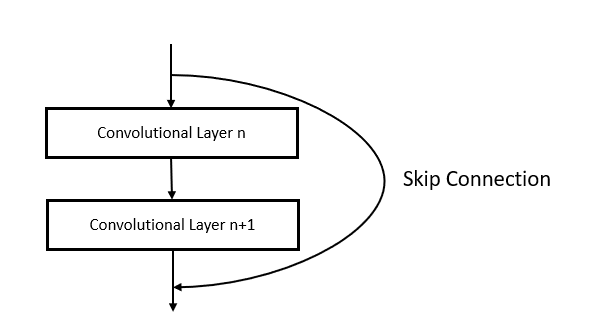

## Custom Implementation
Below, we will create a custom implementation of the ResNet 18-layer model based off the original ResNet paper [1] and an accompanying webpage article [2].

We will heavily utilize Table 1 from the original paper for creating the overall architecture.

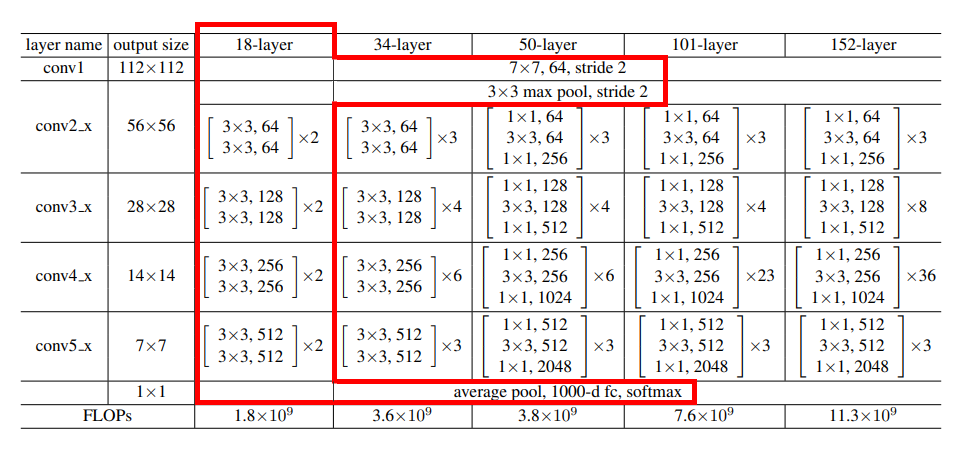

##### Side Note: Why do convolutional layer channels increase?

A channel carries information, just like the 3 RGB channels tell infromation on the red-ness, green-ness, etc. When you combine the channels, you lose information. It becomes imporssible to recover color information if you convert to grayscale. The earlier layers learn basic features, such as vertical lines or dots. Such information needs to be in a seperate channel, because if not, then there would be no way of knowing rather a dot or line is present. When you get to deeper layers, you are learning more complex features, like full faces. These are a lot more complex than basic ones, so more channels will be neccessary to determine the presence of these.

### The Basic Building Block

From the first figure above, we can see the construction of a basic building block for the ResNet architecture. This consists of:
- (conv1) Convolutional layer #1: This will be a 2D convolution with kernel size and number of input/output channels determined from Table 1 
- (bn1) Batch normalization layer #1: Batch normalization is applied after each convolution and before activation. Refer to pg. 3, Section 3.4 Implementation
- (relu) Activation function: ReLu - as specified in Figure 2 on pg. 2
- (conv2) Convolutional layer #2: Another 2D convolutional layer
- (bn2) Batch normalization layer #1: Another batch normalization layer
- skip connection merge
- (relu) Activation function: ReLu

There are many additional parameters that can be specified for the respective PyTorch modules to implement the basic building block. To the best of my ability, I have specified parameters based on details from paper or left them as their default value.

In [1]:
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type

In [2]:
class BasicBlock(nn.Module): # nn.module is basic class for all neural network models
    def __init__(self, in_channels, out_channels, stride, identity_downsample_function):
        super(BasicBlock, self).__init__() # instantiate parent class variables
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.identity_downsample_function = identity_downsample_function
        
    def forward(self, x: Tensor) -> Tensor:
        identity = x 
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # the identity shortcuts can be directly used when the input and output are same dimensions.
        # When dimenions increases, the shortcut is convolved with 1x1 filter w/ stride=2
        if self.identity_downsample_function is not None:
            identity = self.identity_downsample_function(x)
             
        out += identity # this is the power of residual networks
        out = self.relu(out)
        return out
        

### Identity Function
The skip connection can be envisioned as simply combining the input of the basic building block to the output. You can see this clearly from Figure 1 of the original paper. However, in actual implementation, there is a slight nuisance tha needs to be considered. This is when the input of the basic building block is a different size/dimension than the output. When does this occur? Well, this is when the basic building block changes the dimensions of the input. This can be more descriptive. Specifically, this is when the the first convolutional layer increases the dimensions of the ...

### Implementing entire ResNet18 structure with basic building blocks

In [4]:
class ResNet18(nn.Module):
    def __init__(self, image_channels: int, number_classes: int):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=image_channels,
                               out_channels=64, 
                               kernel_size=7, 
                               stride=2, 
                               padding=3) # padding has to equal 3 in order to halve the input dimensions, draw it out on 14x14 image to understand that no other padding amount works
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
                        BasicBlock(64, 64, stride=1, identity_downsample_function=None),
                        BasicBlock(64, 64, stride=1, identity_downsample_function=None))
        self.layer2 = nn.Sequential(
                        BasicBlock(64, 128, stride=2, identity_downsample_function=self.create_downsample_function(64, 128)),
                        BasicBlock(128, 128, stride=1, identity_downsample_function=None))
        self.layer3 = nn.Sequential(
                        BasicBlock(128, 256, stride=2, identity_downsample_function=self.create_downsample_function(128, 256)),
                        BasicBlock(256, 256, stride=1, identity_downsample_function=None))
        self.layer4 = nn.Sequential(
                        BasicBlock(256, 512, stride=2, identity_downsample_function=self.create_downsample_function(256, 512)),
                        BasicBlock(512, 512, stride=1, identity_downsample_function=None))
            
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, number_classes)
            
    def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            
            return x
        
    def create_downsample_function(self, in_channels, out_channels):
        """
        creates downsampling module to match the dimensions of the skip connection to the expected output
        dimensions. Needed where the 'dotted' line connections are on pg. 4 Fig. 3. of original paper
        """
        return nn.Sequential(
                    nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=1, 
                              stride=2),
                    nn.BatchNorm2d(out_channels))

### Verifying Implementation

To verify our implementtion, we can cross-check our implementation with the features described in Table 1 of the original paper.

Our custom implementation utilizes custom parameters for the number of imaging channels (RGB, RGBA, grayscale, etc.) as input, as well as number of classification classes. In order to instantiate our model, we will need to specify these values. For this initial verification, we will use the characteristics of the widely used ImageNet dataset [4]. This is one of the largest datasets and is commonly used to compare the performance of different models. This dataset consists of RGB images and 1000 classes.

In [6]:
IMAGE_CHANNELS = 3 #RGB
NUMBER_CLASSES = 1000

model = ResNet18(IMAGE_CHANNELS, NUMBER_CLASSES)
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

### Total Number of Parameters

In [7]:
total_parameters = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_parameters)
total_trainable_parameters = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters: ", total_trainable_parameters)
# official torchvision resnet18 mdoel has 11,689,512

Total parameters:  11694312
Total trainable parameters:  11694312


The official pytorch ResNet18 model has 11,689,512 parameters [5]. 

### Running a dummy tensor to ensure connections are valid

If everything is connected with correct dimensions, we should get no error raised.

In [8]:
tensor = torch.rand([1,3,224,224])
outout = model(tensor)

## Training ResNet18

We have just implemented our own ResNet18 model, and verified architecture by cross-checking our model architecture with Table 1 from the original ResNet paper and running a dummy tensor to ensure dimensions and connections are correct. 

Let's try actually training our model now to ensure classic deep learning model characteristics are exhibited, such as overall decrease in loss/error during training, and even train on a small dataset to demonstrate somewhat high accuracy. We will use the popular MNIST dataset.

### Training in PyTorch

Great refresher on PyTorch syntax for training is here [5].

#### Download Dataset

In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [10]:
train_data = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
validation_data = datasets.MNIST(root="data", download=True, train=False, transform=ToTensor())

##### DataLoader

DataLoader is a useful PyTorch module to abstract your datasets and make them more flexible. This class also helps with training on smaller batches of the complete dataset. This is a good time to have a refresher on common training hyperparameters, such as batch size.

#### Batch Size
The amount of data to show a model to calculate one round of gradients. Ideally, you could show the entire dataset to the model to calculate error/loss. And when we say "showing data to a model", we mean making a prediction on a group of data. So ideally, we could predict on the entire dataset and then compare the predictions to the expected values to calculate loss. 

However, when predicting with a model, all of the data you wish to "show" at once will be loaded into RAM. With the limitations of your computer, the size of your RAM will limit the amount of data you can show at once. So, with a smaller RAM size, you can not show the entire dataset at once (assuming the dataset is relatively large). You will then ration the amount of data you show to a model at once through the hyperparemeter called batch size.

Commonly, batch size is 64, 128, 256 or 512. However, any number can be used, as long as it is not greater than the dataset size and your memory can accomodate it. 

Having common values for hyperparameters is actually a frequent occurence. There is the process of hyperparameter tuning in which the optimal values for hyperparameters are chosens, i.e. the optimal values that produce the highest performing trained model. However, as these values can be any number, there is simply too many to test. Therefore, there is commonly a predefined set of values for each hyperparameter.

In [11]:
BATCH_SIZE = 128

In [12]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
valid_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE)

##### Dataset Characteristics

MNIST is a dataset of hand-written digits in grayscale format with image size of 28x28.

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([128, 1, 28, 28])


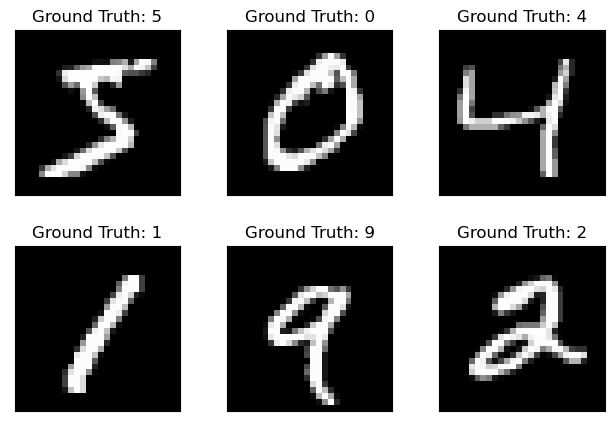

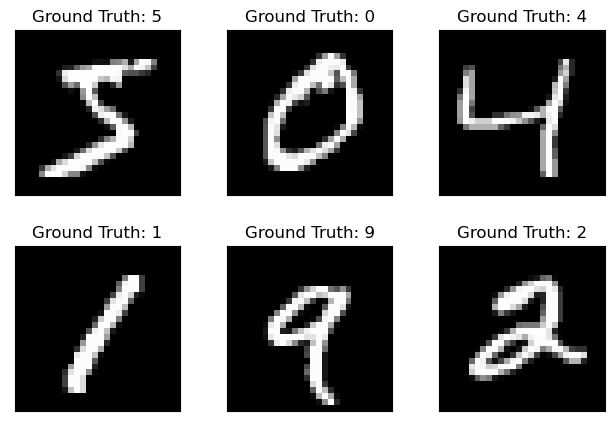

In [13]:
print(train_data)
print(validation_data)

examples = enumerate(train_data_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

##### CUDA

My development workstation contains a NVIDIA GPU. So lets utilize CUDA capabilities to improve training time.

In [14]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.6
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [15]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

Using cuda device


#### Training Model

Reminder, we are using the MNIST dataset. The images are 28x28x1, and there are 10 different classes (numbers 0-9).

In [16]:
IMAGE_CHANNELS = 1
NUMBER_CLASSES = 10

resnet18_model = ResNet18(IMAGE_CHANNELS,NUMBER_CLASSES).to(device)

#### Epoch

An epoch is when the model has seen the entire dataset. For example, if the dataset size is 1000, and the batch size is 500, then an epoch is completed when 2 batches have been shown to the model.

In [23]:
EPOCHS = 10

How to structure a training loop. Good intro on overall layout [5]. Description including validation testing [7]. Catchy jingle [8].

In [18]:
def train_one_epoch(model, train_data_loader, valid_data_loader, loss_fn, optimizer, device):
    
    # set to train mode
    model.train()
    
    # zero training loss accumulator for each epoch
    train_loss = 0.0
    
    for inputs, targets in train_data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # forward pass
        predictions = model(inputs)
        
        # calculate loss
        loss = loss_fn(predictions, targets)
        
        #  zero gradients
        optimizer.zero_grad() # zeroing our the gradients from prev. iterations, needed to start from scratch in each training iteration
        
        # backpropogate loss
        loss.backward()
        
        # update weights
        optimizer.step()
        
        train_loss += loss.item()
        
    # Test time
    model.eval()
    
    # zero validation loss for each epoch
    valid_loss = 0.0
    
    # prevent gradient calculations
    with torch.no_grad():
        # using different variable names as training for-loop to show different options
        for data, labels in valid_data_loader:
            data, labels = data.to(device), labels.to(device)

            # forward pass
            predictions = model(data)

            loss = loss_fn(predictions, labels)

            valid_loss += loss.item()
    
    print(f"Training Loss: {train_loss / len(train_data_loader)}, Validation Loss: {valid_loss / len(valid_data_loader)}")
    
    #if prev_valid_loss > valid_loss:
    #    print(f"Validation Loss Decreased({prev_valid_loss}--->{valid_loss}) Saving The Model")
    #     
    #    # Saving State Dict
    #    torch.save(model.state_dict(), 'saved_model.pth')

In [19]:
def train(model, train_data_loader, valid_data_loader, loss_fn, optimizer, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_one_epoch(model, train_data_loader, valid_data_loader, loss_fn, optimizer, device)
        print("-------------------")
        
    print("Training complete")

#### Learning Rate

The size of the step taken when correcting parameters after backpropogation.

#### Momentum

An extension of gradient decent that builds intertia in a search direction to overcome local minima and oscillations of noisy gradients.

#### Weigt Decay

A regularization technique to prevent overfitting. This method will add a penalty term to the cost function to help reduce the size of model weights. Larger weights correspond to more activate neurons that will use this power to fit more closely to the training data. This is what we don't want. By reducing the power of neurons, we force the model to looks for more frequent patterns throughout the training dataset.

In [20]:
LEARNING_RATE = .001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001

There are numerous options for the loss function and optimization algorithm. Commonly though, cross entropy loss and Adam optimizer are used.

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr = LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [25]:
train(resnet18_model, train_data_loader, valid_data_loader, loss_fn, optimizer, device, EPOCHS)

Epoch 1
Training Loss: 0.15065558730135126, Validation Loss: 0.06246560049991866
-------------------
Epoch 2
Training Loss: 0.03368250615145169, Validation Loss: 0.053285058913826115
-------------------
Epoch 3
Training Loss: 0.011473617125200782, Validation Loss: 0.04118296417819013
-------------------
Epoch 4
Training Loss: 0.00432564110830806, Validation Loss: 0.038951177896971
-------------------
Epoch 5
Training Loss: 0.0015599732104941322, Validation Loss: 0.03623776529491783
-------------------
Epoch 6
Training Loss: 0.0006600253582757184, Validation Loss: 0.035947904086979295
-------------------
Epoch 7
Training Loss: 0.00044098517816597673, Validation Loss: 0.03627290606055806
-------------------
Epoch 8
Training Loss: 0.0003497879989347783, Validation Loss: 0.03655383501902317
-------------------
Epoch 9
Training Loss: 0.0002929624900996148, Validation Loss: 0.03681266604810764
-------------------
Epoch 10
Training Loss: 0.0002530814761675133, Validation Loss: 0.0370499890427

In [96]:
torch.save(resnet18_model.state_dict(), "resnet18.pth")

#### Updated Training Loop

After using the above resources to create the training loop, I am exploring different ways to lay it out. They function the same, but other ways can provide more insight during training. This layout it derived from [9].

In [152]:
def train(model, train_data_loader, valid_data_loader, loss_fn, optimizer, device, epochs):
    
    # creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': []
    } 
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        
        # set to train mode
        model.train()
        train_losses = []
        
        print("training...")
        
        for data, labels in train_data_loader:
            data, labels = data.to(device), labels.to(device)

            # forward pass
            predictions = model(data)

            # calculate loss
            loss = loss_fn(predictions, labels)
            log_dict['training_loss_per_batch'].append(loss.item())
            train_losses.append(loss.item())

            #  zero gradients
            optimizer.zero_grad() # zeroing our the gradients from prev. iterations, needed to start from scratch in each training iteration

            # backpropogate loss
            loss.backward()

            # update weights
            optimizer.step()

        # validation time
        model.eval()
        valid_losses = []

        print("validating...")
        
        # prevent gradient calculations
        with torch.no_grad():
            # using different variable names as training for-loop to show different options
            for data, labels in valid_data_loader:
                data, labels = data.to(device), labels.to(device)

                # forward pass
                predictions = model(data)

                # calculate loss
                loss = loss_fn(predictions, labels)
                log_dict['validation_loss_per_batch'].append(loss.item())
                valid_losses.append(loss.item())

        train_loss = np.array(train_losses).mean()
        valid_loss = np.array(valid_losses).mean()
        
        print(f"Training Loss: {train_loss}, Validation Loss: {valid_loss}")
        
    return log_dict

In [153]:
train_log = train(resnet18_model, train_data_loader, valid_data_loader, loss_fn, optimizer, device, EPOCHS)

Epoch 1
training...
validating...
Training Loss: 0.00673574687910037, Validation Loss: 0.049459412060357436
Epoch 2
training...
validating...
Training Loss: 0.008983602153033244, Validation Loss: 0.03775598818754565
Epoch 3
training...
validating...
Training Loss: 0.006646406873682017, Validation Loss: 0.04049042416791859
Epoch 4
training...
validating...
Training Loss: 0.0040996025795512455, Validation Loss: 0.05278332492663381
Epoch 5
training...
validating...
Training Loss: 0.005860121636274433, Validation Loss: 0.04518254677323863


## Sources
[1] https://arxiv.org/abs/1512.03385

[2] https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

[3] https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch

[4] https://www.image-net.org/

[5] https://www.youtube.com/watch?v=4p0G6tgNLis

[6] https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

[7] https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

[8] https://www.youtube.com/watch?v=Nutpusq_AFw

[9] https://blog.paperspace.com/training-validation-and-accuracy-in-pytorch/